In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import tensorflow as tf

# Set seeds
np.random.seed(10)
tf.set_random_seed(10)

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout
from tensorflow.keras.layers import Conv1D, TimeDistributed, UpSampling1D, MaxPooling1D


from tensorflow.keras import optimizers, models, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler

In [2]:
%matplotlib inline
import seaborn as sns
import re
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import matplotlib.ticker as mtick
mpl.rcParams['ps.useafm'] = True
#mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True
mpl.rc('text', usetex=True) 
mpl.rcParams['text.latex.unicode']=True
mpl.use( "cairo", warn=False, force=True)
print(mpl.pyplot.get_backend())

mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage[T1]{fontenc}',
       r'\usepackage[default]{gillius}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  


def init_plotting():
    plt.rcParams['figure.figsize'] = (8, 5)
    plt.rcParams['font.size'] = 20
    print(plt.rcParams['font.family'] )
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = plt.rcParams['font.size']
    plt.rcParams['legend.fontsize'] = 0.9*plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
#    print(plt.rcParams['savefig.dpi'])
#    plt.rcParams['savefig.dpi'] = 2*plt.rcParams['savefig.dpi']
    plt.rcParams['xtick.minor.visible']=False
    plt.rcParams['ytick.minor.visible']=False
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['xtick.minor.width'] = 2
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['ytick.minor.width'] = 2
    plt.rcParams['ytick.color'] = "black"#"#808080"
    plt.rcParams['xtick.color'] = "black"#"#808080"
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    #ax.tick_params(direction='out', length=6, width=2, colors='r',
    #           grid_color='r', grid_alpha=0.5)
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.loc'] = 'best'
    plt.rcParams['axes.linewidth'] = 2

init_plotting()

def hide_spines():
    """Hides the top and rightmost axis spines from view for all active
    figures and their respective axes."""
    # Retrieve a list of all current figures.
    figures = [x for x in mpl._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            
            ax.spines['left'].set_color("#808080")
            ax.spines['bottom'].set_color("#808080")
            ax.spines['right'].set_color("#808080")
            ax.spines['top'].set_color("#808080")
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
            ax.spines['top'].set_linewidth(0.1)
            ax.spines['top'].set_linestyle(':')
            ax.spines['right'].set_linewidth(0.1)
            ax.spines['right'].set_linestyle(':')

hide_spines()

cairo
['sans-serif']


/home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  import sys
/home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  


### Some global variables

In [3]:
Rnum = 1000
num_time_steps = 100
x = np.linspace(0.0,1.0,num=128)
dx = 1.0/np.shape(x)[0]
tsteps = np.linspace(0.0,2.0,num=num_time_steps)
dt = 2.0/np.shape(tsteps)[0]
time_window = 10 # The window size of the LSTM
mode = 'test'

### Functions for full-order snapshots of Burgers Equation

In [4]:
def exact_solution(Rnum,t):
    t0 = np.exp(Rnum/8.0)
    return (x/(t+1))/(1.0+np.sqrt((t+1)/t0)*np.exp(Rnum*(x*x)/(4.0*t+4)))

def collect_snapshots(Rnum):
    snapshot_matrix = np.zeros(shape=(np.shape(x)[0],np.shape(tsteps)[0]))

    trange = np.arange(np.shape(tsteps)[0])
    for t in trange:
        snapshot_matrix[:,t] = exact_solution(Rnum,tsteps[t])[:]

    return snapshot_matrix

def collect_multiparam_snapshots_train():
    rnum_vals = np.arange(100,2000,100)
    
    rsnap = 0
    for rnum_val in rnum_vals:
        snapshots_temp = np.transpose(collect_snapshots(rnum_val))
        
        if rsnap == 0:
            all_snapshots = snapshots_temp
        else:
            
            all_snapshots = np.concatenate((all_snapshots,snapshots_temp),axis=0)
            
        rsnap = rsnap + 1    
    return all_snapshots, rnum_vals/1000

def collect_multiparam_snapshots_test():
    rnum_vals = np.arange(50,2500,200)
    
    rsnap = 0
    for rnum_val in rnum_vals:
        snapshots_temp = np.transpose(collect_snapshots(rnum_val))
        
        if rsnap == 0:
            all_snapshots = snapshots_temp
        else:
            
            all_snapshots = np.concatenate((all_snapshots,snapshots_temp),axis=0)
            
        rsnap = rsnap + 1    
    return all_snapshots, rnum_vals/1000

### Collect some snapshot data for CNN-LSTM embedding

In [5]:
snapshots_train, rnum_vals_train = collect_multiparam_snapshots_train() # So that dim=0 corresponds to number of snapshots
snapshots_test, rnum_vals_test = collect_multiparam_snapshots_test() # So that dim=0 corresponds to number of snapshots

snapshots_train = np.expand_dims(snapshots_train,-1)
snapshots_test = np.expand_dims(snapshots_test,-1)

### ML related presets

In [6]:
weights_filepath = 'best_weights_ae.h5'
lrate = 0.001

def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Autoencoder

In [7]:
# Define recursive model architecture

## Encoder
encoder_inputs = Input(shape=(128,1),name='Field')
# Encode   
x = Conv1D(25,kernel_size=3,activation='relu',padding='same')(encoder_inputs)
enc_l2 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(15,kernel_size=3,activation='relu',padding='same')(enc_l2)
enc_l3 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(10,kernel_size=3,activation='relu',padding='same')(enc_l3)
enc_l4 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(5,kernel_size=3,activation='relu',padding='same')(enc_l4)
enc_l5 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(1,kernel_size=3,activation=None,padding='same')(enc_l5)
enc_l6 = MaxPooling1D(2,padding='same')(x)

x = Conv1D(1,kernel_size=3,activation=None,padding='same')(enc_l6)
encoded = MaxPooling1D(2,padding='same')(x)

# x = Conv1D(1,kernel_size=3,activation=None,padding='same')(enc_l7)
# encoded = MaxPooling1D(2,padding='same')(x)

encoder = Model(inputs=encoder_inputs,outputs=encoded)
    
## Decoder
decoder_inputs = Input(shape=(2,1),name='decoded')

x = Conv1D(1,kernel_size=3,activation=None,padding='same')(decoder_inputs)
dec_l1 = UpSampling1D(2)(x)

x = Conv1D(5,kernel_size=3,activation='relu',padding='same')(dec_l1)
dec_l2 = UpSampling1D(2)(x)

x = Conv1D(10,kernel_size=3,activation='relu',padding='same')(dec_l2)
dec_l3 = UpSampling1D(2)(x)

x = Conv1D(15,kernel_size=3,activation='relu',padding='same')(dec_l3)
dec_l4 = UpSampling1D(2)(x)

x = Conv1D(20,kernel_size=3,activation='relu',padding='same')(dec_l4)
dec_l5 = UpSampling1D(2)(x)

x = Conv1D(25,kernel_size=3,activation='relu',padding='same')(dec_l5)
dec_l6 = UpSampling1D(2)(x)

# x = Conv1D(20,kernel_size=3,activation='relu',padding='same')(dec_l6)
# dec_l7 = UpSampling1D(2)(x)

decoded = Conv1D(1,1,activation=None,padding='same')(dec_l6)
    
decoder = Model(inputs=decoder_inputs,outputs=decoded)

## Autoencoder
ae_outputs = decoder(encoder(encoder_inputs))
  
model = Model(inputs=encoder_inputs,outputs=ae_outputs,name='CAE')
    
# design network
my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint]

# fit network
model.compile(optimizer=my_adam,loss='mean_squared_error',metrics=[coeff_determination])    
model.summary()

num_epochs = 500
batch_size = 32

if mode == 'train':
    train_history = model.fit(x=snapshots_train, y=snapshots_train, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list)

W1122 18:26:43.174748 139638247184192 deprecation.py:506] From /home/rmlans/anaconda3/envs/deephyper_env/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "CAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Field (InputLayer)           [(None, 128, 1)]          0         
_________________________________________________________________
model (Model)                (None, 2, 1)              1875      
_________________________________________________________________
model_1 (Model)              (None, 128, 1)            3120      
Total params: 4,995
Trainable params: 4,995
Non-trainable params: 0
_________________________________________________________________


### Check accuracy

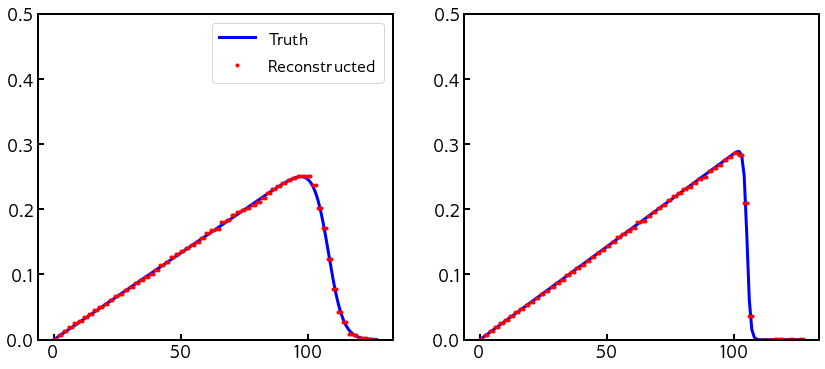

In [8]:
model.load_weights(weights_filepath)
sim_num = 2
recoded_1 = model.predict(snapshots_train[(sim_num+1)*(num_time_steps-1):(sim_num+1)*(num_time_steps-1)+1,:,0:])
sim_num = 12
recoded_2 = model.predict(snapshots_train[(sim_num+1)*(num_time_steps-1):(sim_num+1)*(num_time_steps-1)+1,:,0:])

sim_num = 2
fig, ax = plt.subplots(figsize=(14,6),nrows=1,ncols=2)
ax[0].plot(snapshots_train[(sim_num+1)*(num_time_steps-1),:,0:],'b',label='Truth',linewidth=3)
ax[0].plot(recoded_1[0,:,0:],'ro',label='Reconstructed',markersize=3)

sim_num = 12
ax[1].plot(snapshots_train[(sim_num+1)*(num_time_steps-1),:,0:],'b',label='Truth',linewidth=3)
ax[1].plot(recoded_2[0,:,0:],'ro',label='Reconstructed',markersize=3)

ax[0].legend()

ax[0].set_ylim((0,0.5))
ax[1].set_ylim((0,0.5))

plt.show()

### Generate encoded data for LSTM learning

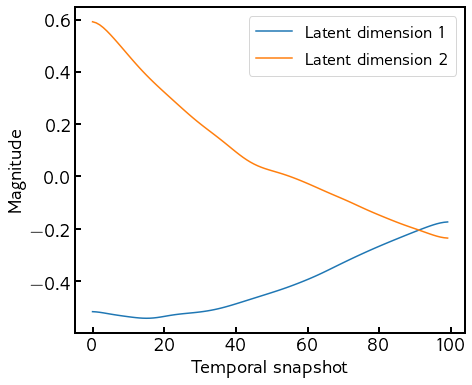

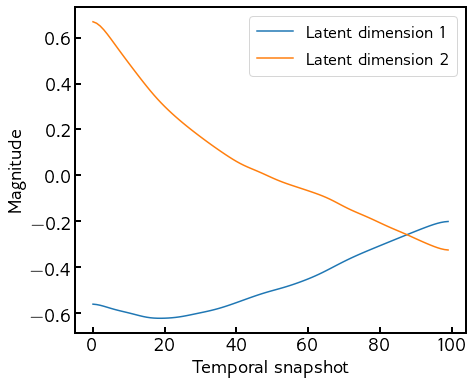

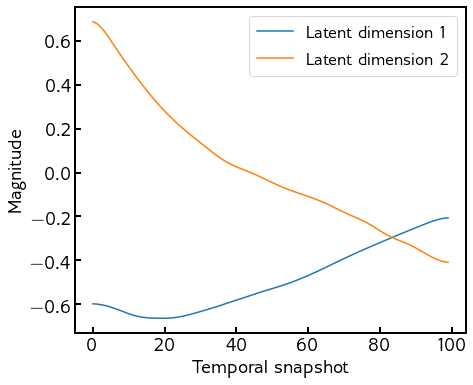

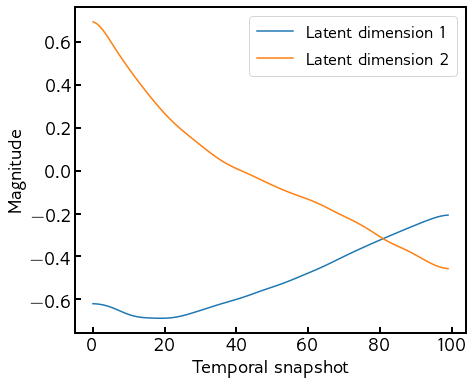

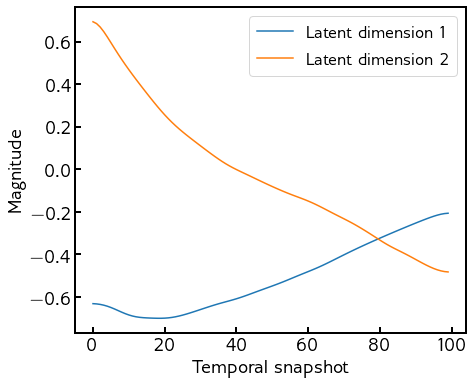

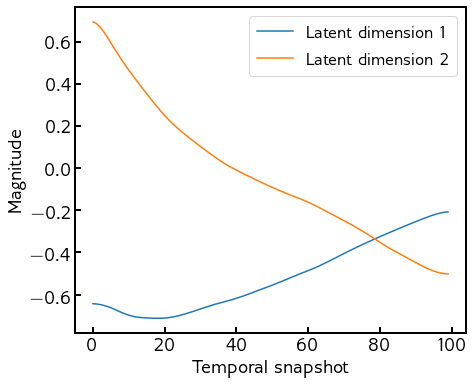

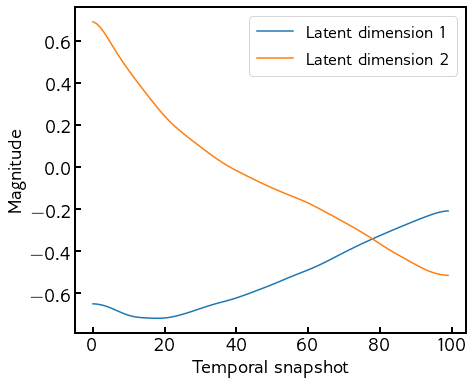

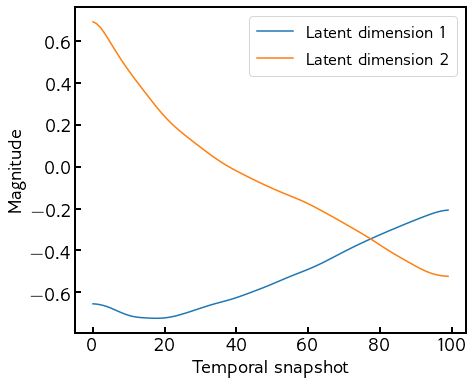

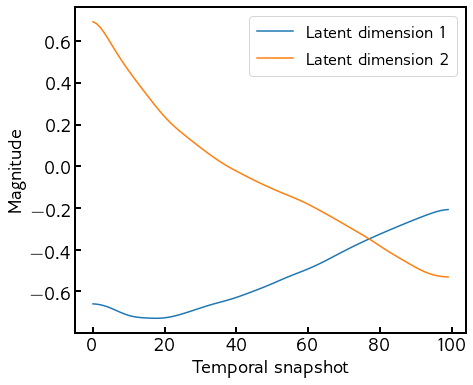

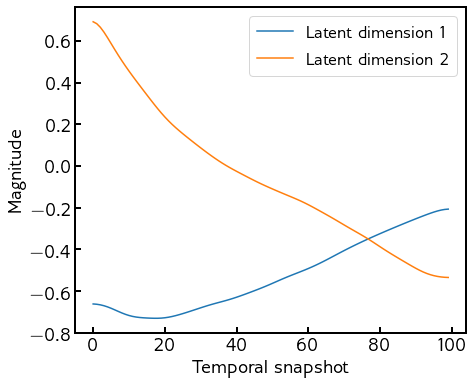

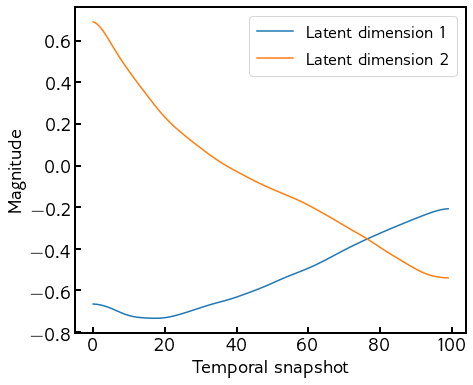

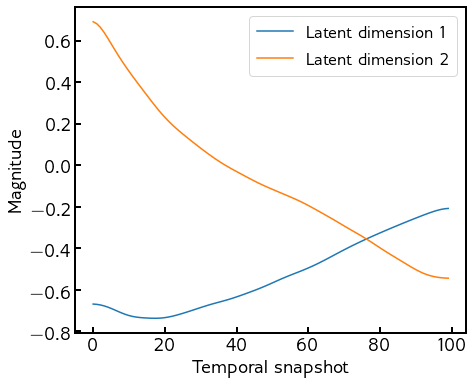

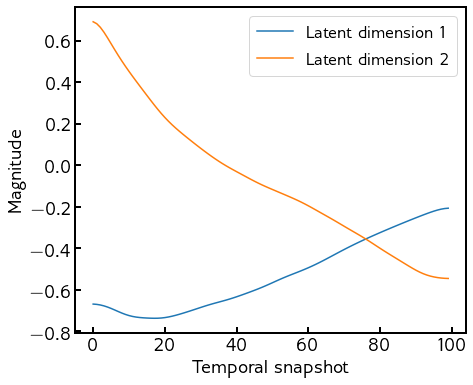

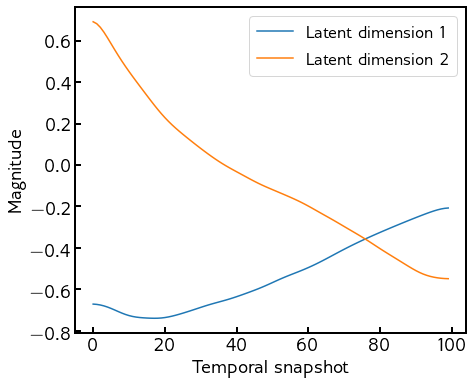

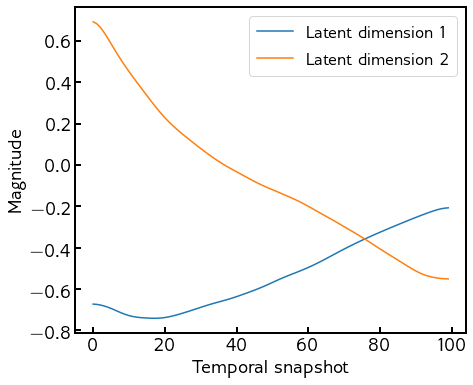

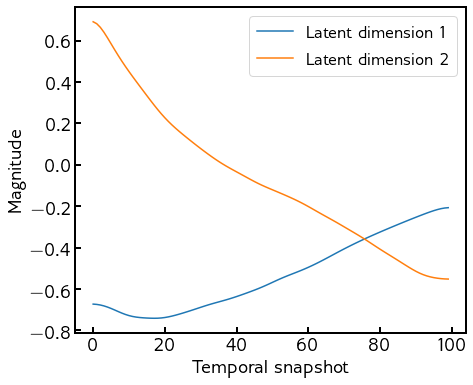

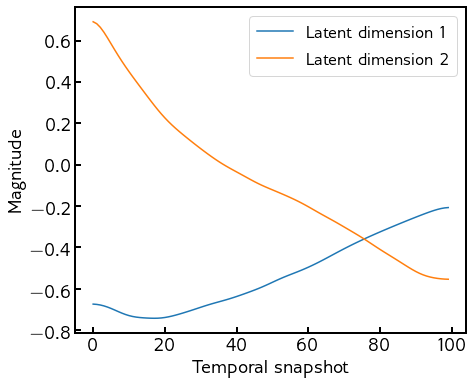

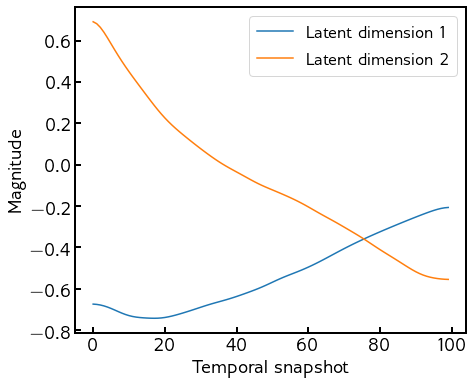

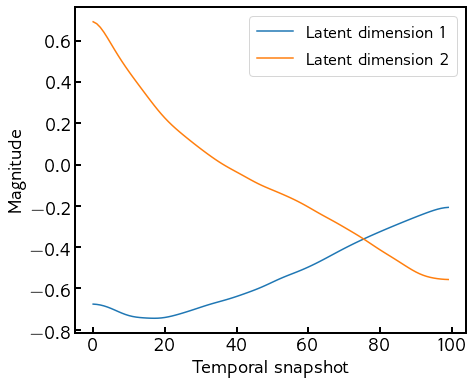

In [9]:
# Train
encoded = K.eval(encoder(snapshots_train[:,:,0:].astype('float32')))
# Reshape
encoded = encoded.reshape(len(rnum_vals_train),num_time_steps,2)
# Test
encoded_test = K.eval(encoder(snapshots_test[:,:,0:].astype('float32')))
# Reshape
encoded_test = encoded_test.reshape(len(rnum_vals_test),num_time_steps,2)

from scipy.ndimage.filters import gaussian_filter1d
encoded_f = np.copy(encoded)
encoded_test_f = np.copy(encoded_test)

for rnum in range(len(rnum_vals_train)):
    encoded_f[rnum,:,0] = gaussian_filter1d(encoded[rnum,:,0],sigma=3)
    encoded_f[rnum,:,1] = gaussian_filter1d(encoded[rnum,:,1],sigma=3)

for rnum in range(len(rnum_vals_test)):
    encoded_test_f[rnum,:,0] = gaussian_filter1d(encoded_test[rnum,:,0],sigma=3)
    encoded_test_f[rnum,:,1] = gaussian_filter1d(encoded_test[rnum,:,1],sigma=3)

    
for i in range(len(rnum_vals_train)):
    plt.figure(figsize=(7,6))
    plt.plot(encoded_f[i,:,0],label='Latent dimension 1')
    plt.plot(encoded_f[i,:,1],label='Latent dimension 2')
    plt.legend()
    plt.xlabel('Temporal snapshot')
    plt.ylabel('Magnitude')
    plt.show()

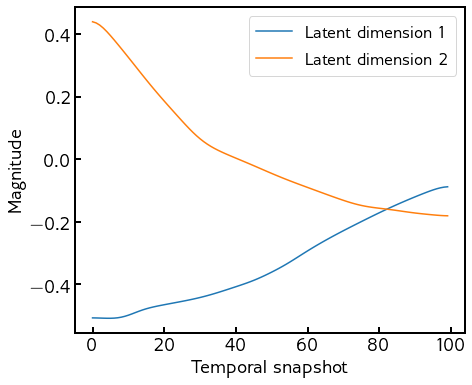

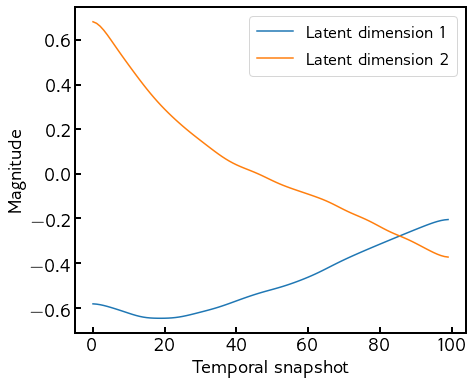

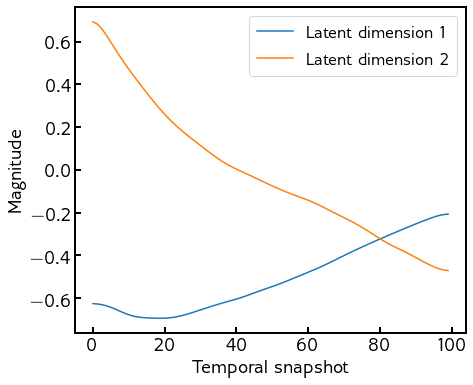

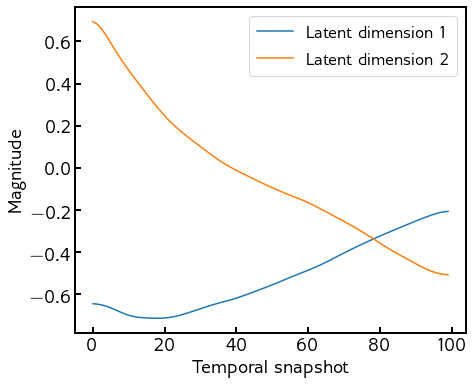

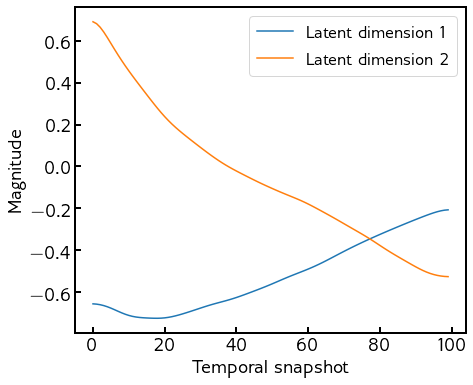

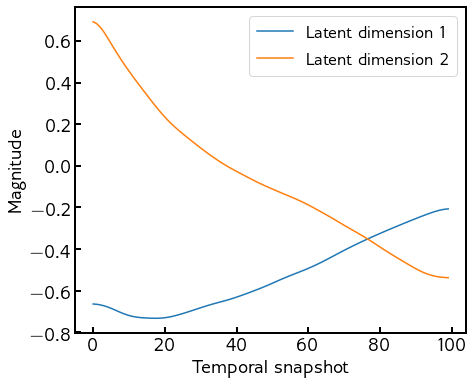

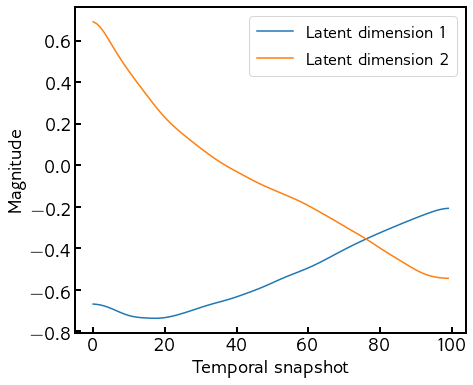

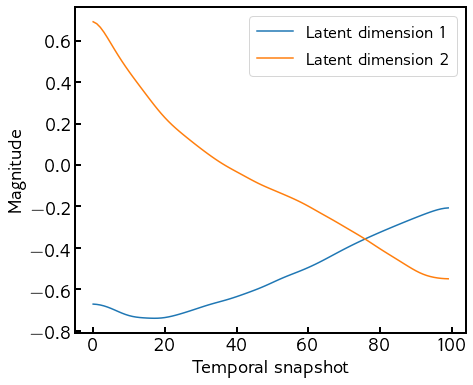

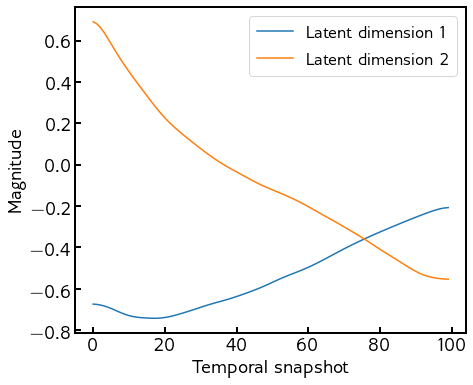

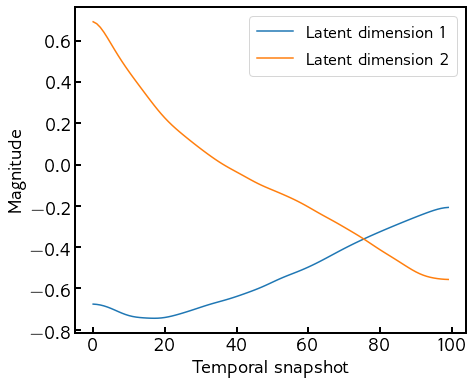

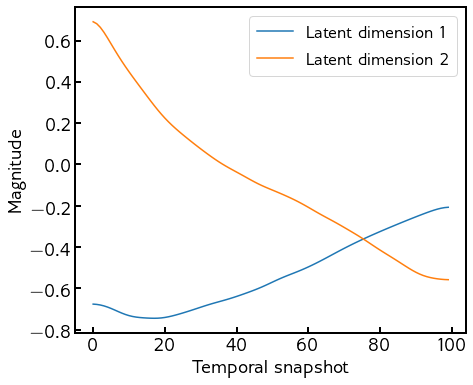

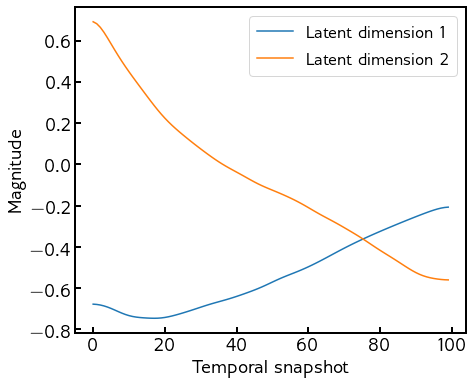

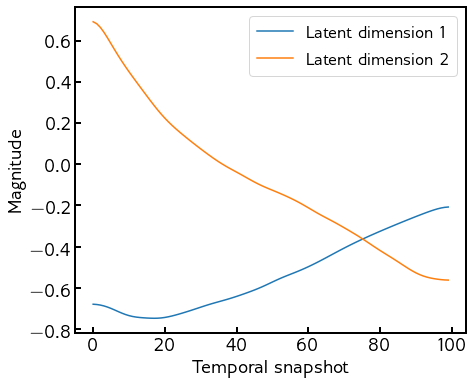

In [10]:
for i in range(len(rnum_vals_test)):
    plt.figure(figsize=(7,6))
    plt.plot(encoded_test_f[i,:,0],label='Latent dimension 1')
    plt.plot(encoded_test_f[i,:,1],label='Latent dimension 2')
    plt.legend()
    plt.xlabel('Temporal snapshot')
    plt.ylabel('Magnitude')
    plt.show()

### Train LSTM with parameter information

In [11]:
num_train_snapshots = np.shape(rnum_vals_train)[0]

rnum_tracker = np.zeros(shape=(num_train_snapshots,num_time_steps,1))
for i in range(np.shape(rnum_vals_train)[0]):
    rnum_tracker[i,:,0] = rnum_vals_train[i]
    
lstm_training_data = np.concatenate((encoded,rnum_tracker),axis=-1)

total_size = np.shape(lstm_training_data)[0]*np.shape(lstm_training_data)[1]
total_size_sim = np.shape(lstm_training_data)[1]

from sklearn.preprocessing import MinMaxScaler
scale_lstm = False
if scale_lstm:
    scaler = MinMaxScaler()
    lstm_training_data_scaled = scaler.fit_transform(lstm_training_data[0,:,:])
else:
    lstm_training_data_scaled = lstm_training_data[0,:,:]

# Shape the inputs and outputs
input_seq = np.zeros(shape=(total_size-num_train_snapshots*time_window,time_window,3))
output_seq = np.zeros(shape=(total_size-num_train_snapshots*time_window,2))

# Setting up inputs
sample = 0
for snum in range(num_train_snapshots):
    for t in range(time_window,total_size_sim):
        input_seq[sample,:,:] = lstm_training_data[snum,t-time_window:t,:]
        output_seq[sample,:] = lstm_training_data[snum,t,0:2]
        sample = sample + 1

In [12]:
# Model architecture
lstm_model = models.Sequential()
lstm_model.add(LSTM(40,input_shape=(time_window, 3),return_sequences=True))  #
lstm_model.add(LSTM(40,input_shape=(time_window, 3),return_sequences=False))  #
lstm_model.add(Dense(2, activation=None))

# training parameters
num_epochs = 3000
batch_size = 32


# design network
lstm_filepath = 'lstm_weights.h5'
lstm_adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
checkpoint = ModelCheckpoint(lstm_filepath, monitor='loss', verbose=0, save_best_only=True, mode='min',save_weights_only=True)
earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
lstm_callbacks_list = [checkpoint]

# fit network
lstm_model.compile(optimizer=lstm_adam,loss='mean_squared_error',metrics=[coeff_determination])

lstm_model.summary()

if mode == 'train':
    lstm_train_history = lstm_model.fit(input_seq, output_seq, epochs=num_epochs, batch_size=batch_size, callbacks=lstm_callbacks_list)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 40)            7040      
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense (Dense)                (None, 2)                 82        
Total params: 20,082
Trainable params: 20,082
Non-trainable params: 0
_________________________________________________________________


### Test LSTM with parameter information

In [13]:
num_test_snapshots = np.shape(rnum_vals_test)[0]
lstm_model.load_weights(lstm_filepath)

rnum_tracker = np.zeros(shape=(num_test_snapshots,num_time_steps,1))
for i in range(np.shape(rnum_vals_test)[0]):
    rnum_tracker[i,:,0] = rnum_vals_test[i]
    
lstm_testing_data = np.concatenate((encoded_test,rnum_tracker),axis=-1)

total_size = np.shape(lstm_testing_data)[0]*np.shape(lstm_testing_data)[1]
total_size_sim = np.shape(lstm_testing_data)[1]

scale_lstm = False
for i in range(np.shape(rnum_vals_test)[0]):
    if scale_lstm:
        lstm_testing_data[i,:,:] = scaler.transform(lstm_testing_data[i,:,:])

# Shape the inputs and outputs
input_seq = np.zeros(shape=(1,time_window,3))
output_seq = np.zeros(shape=(total_size-num_test_snapshots*time_window,2))
output_seq_pred = np.zeros(shape=(total_size-num_test_snapshots*time_window,2))

# Setting up inputs
sample = 0
for snum in range(num_test_snapshots):
    input_seq[0,:,:] = lstm_testing_data[snum,0:time_window,:]
    for t in range(time_window,total_size_sim):
#         input_seq[0,:,:] = lstm_testing_data[snum,t-time_window:t,:]
        output_seq_pred[sample,:] = lstm_model.predict(input_seq[0:1,:,:])[0,:]
        output_seq[sample,:] = lstm_testing_data[snum,t,0:2]
        input_seq[0,0:time_window-1,:] = input_seq[0,1:,:] 
        input_seq[0,time_window-1,:2] = output_seq_pred[sample,:]
        sample = sample + 1

### Check quality in latent space for testing data

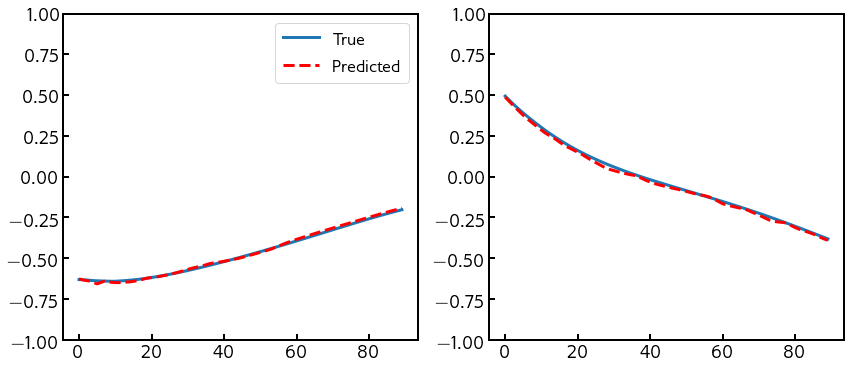

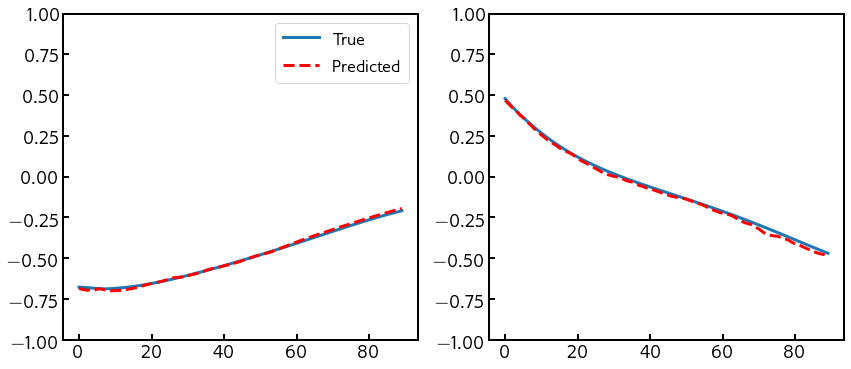

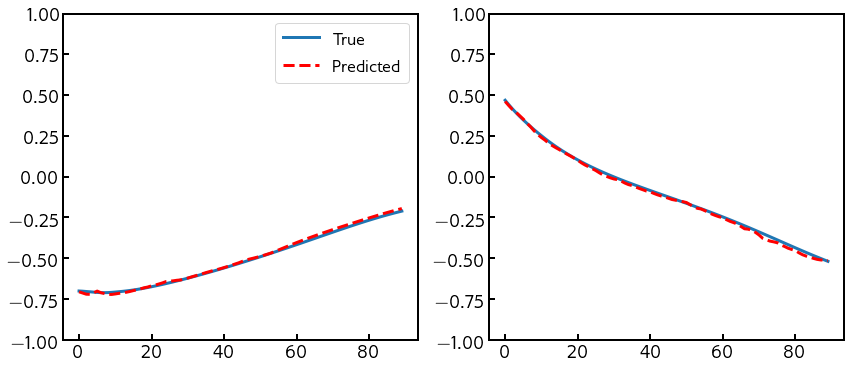

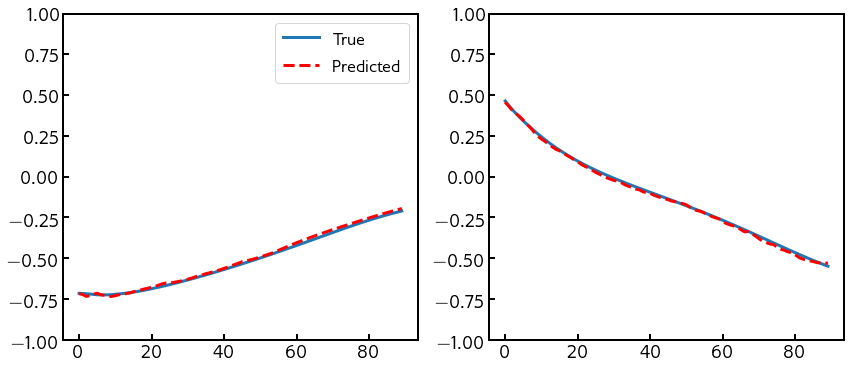

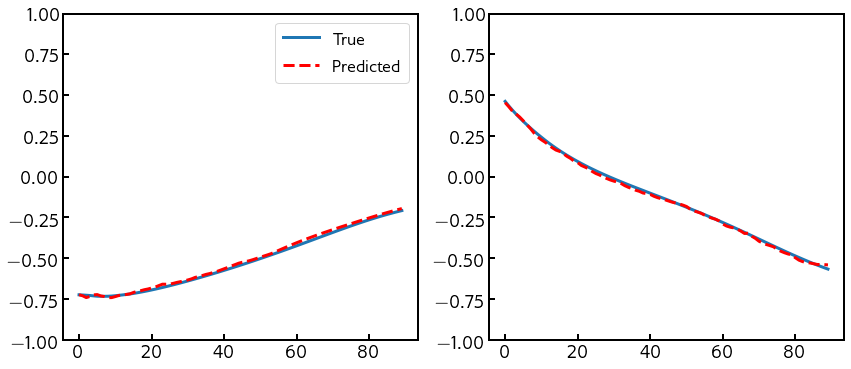

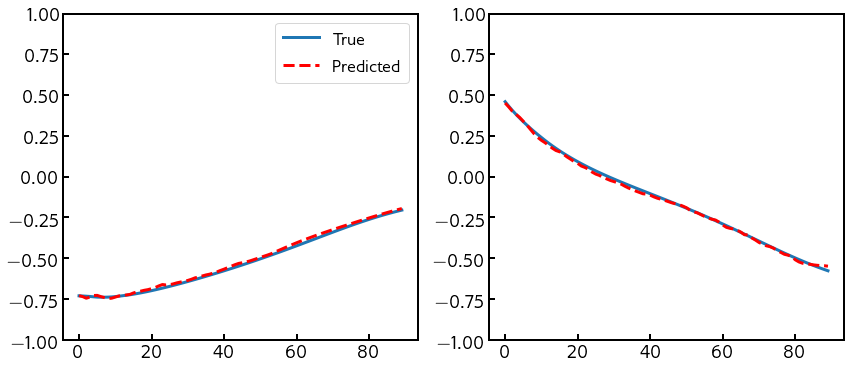

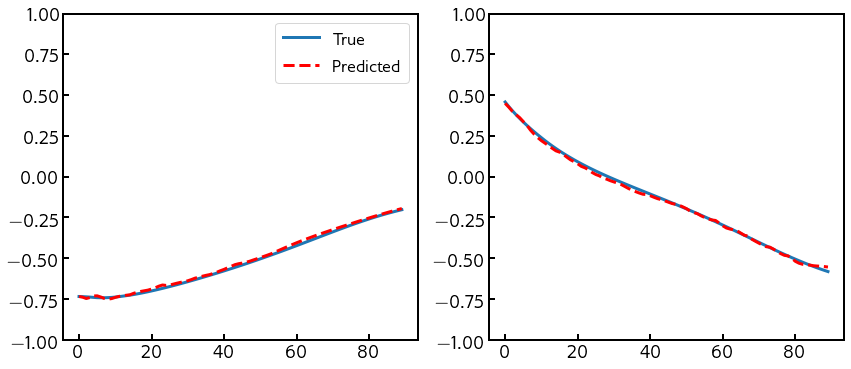

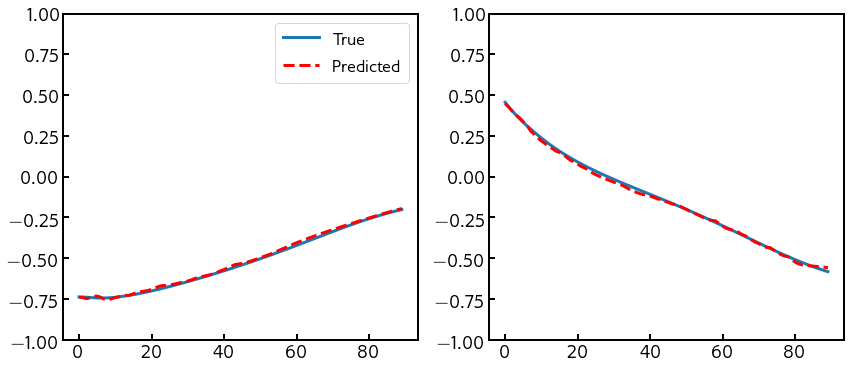

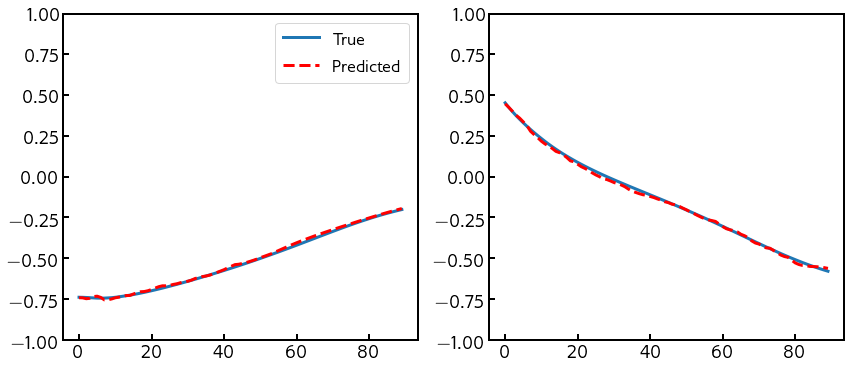

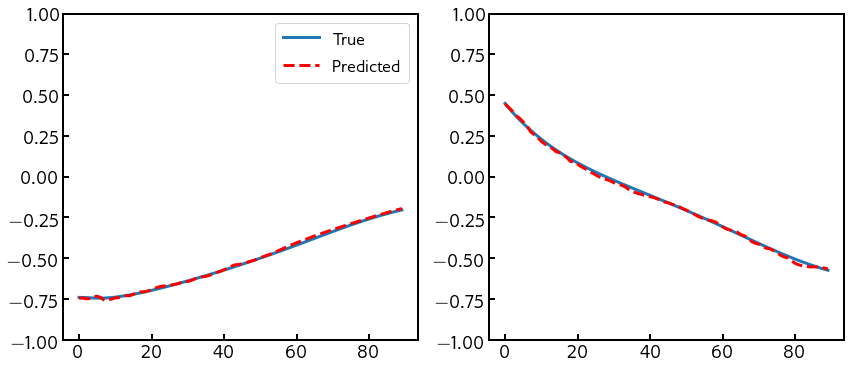

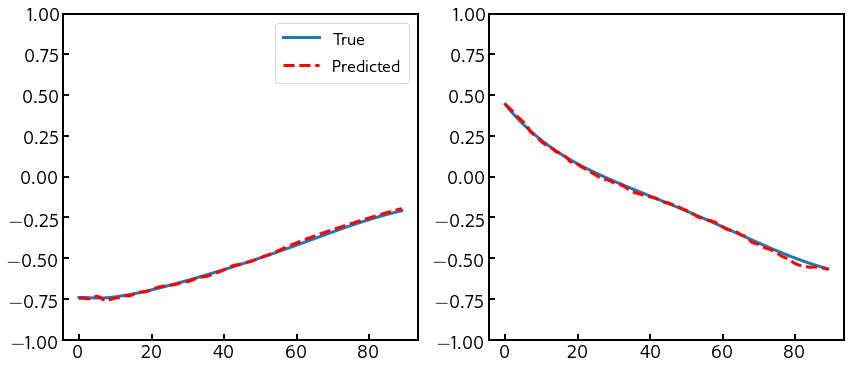

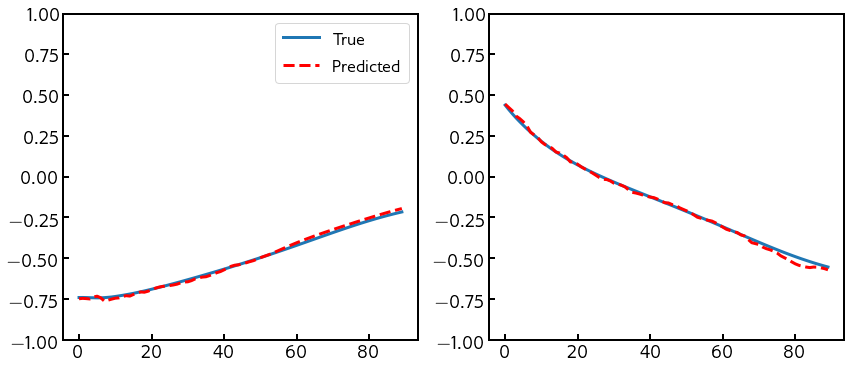

In [14]:
for sim_num in range(1,num_test_snapshots):
    fig, ax = plt.subplots(figsize=(14,6),nrows=1, ncols=2)

    ax[0].plot(output_seq_pred[sim_num*(num_time_steps-time_window):(sim_num+1)*(num_time_steps-time_window),0],label='True',linewidth=3)
    ax[0].plot(lstm_testing_data[sim_num,time_window:,0],'r--',label='Predicted',linewidth=3)

    ax[1].plot(output_seq_pred[sim_num*(num_time_steps-time_window):(sim_num+1)*(num_time_steps-time_window),1],label='True',linewidth=3)
    ax[1].plot(lstm_testing_data[sim_num,time_window:,1],'r--',label='Predicted',linewidth=3)

    ax[0].legend()
    ax[0].set_ylim((-1,1))
    ax[1].set_ylim((-1,1))
    plt.show()

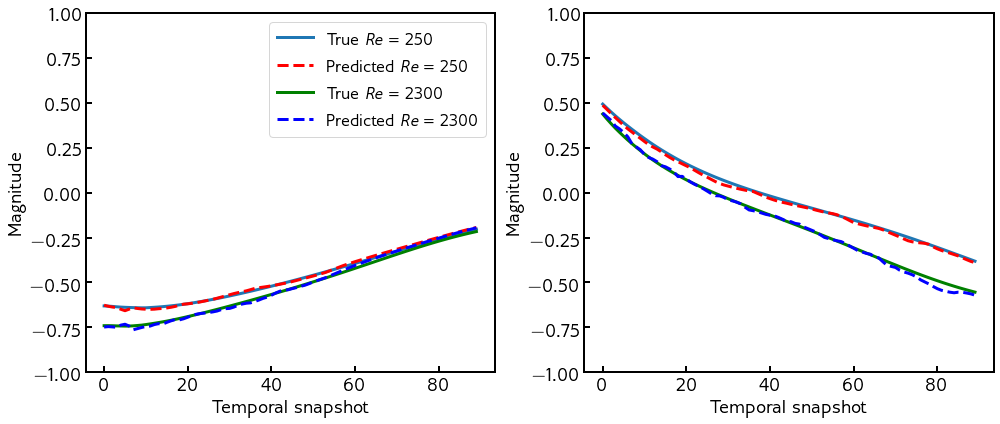

In [15]:
fig, ax = plt.subplots(figsize=(14,6),nrows=1, ncols=2)

sim_num = 1
ax[0].plot(output_seq_pred[sim_num*(num_time_steps-time_window):(sim_num+1)*(num_time_steps-time_window),0],label='True $Re=250$',linewidth=3)
ax[0].plot(lstm_testing_data[sim_num,time_window:,0],'r--',label=r'Predicted $Re=250$',linewidth=3)

ax[1].plot(output_seq_pred[sim_num*(num_time_steps-time_window):(sim_num+1)*(num_time_steps-time_window),1],label='True $Re=250$',linewidth=3)
ax[1].plot(lstm_testing_data[sim_num,time_window:,1],'r--',label=r'Predicted $Re=250$',linewidth=3)


sim_num = num_test_snapshots-1
ax[0].plot(output_seq_pred[sim_num*(num_time_steps-time_window):(sim_num+1)*(num_time_steps-time_window),0],label='True $Re=2300$',linewidth=3,color='green')
ax[0].plot(lstm_testing_data[sim_num,time_window:,0],'b--',label=r'Predicted $Re=2300$',linewidth=3)

ax[1].plot(output_seq_pred[sim_num*(num_time_steps-time_window):(sim_num+1)*(num_time_steps-time_window),1],label='True $Re=2300$',linewidth=3,color='green')
ax[1].plot(lstm_testing_data[sim_num,time_window:,1],'b--',label=r'Predicted $Re=2300$',linewidth=3)


ax[0].legend()
ax[0].set_ylim((-1,1))
ax[1].set_ylim((-1,1))

ax[0].set_xlabel('Temporal snapshot')
ax[0].set_ylabel('Magnitude')

ax[1].set_xlabel('Temporal snapshot')
ax[1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()

In [16]:
output_seq_pred = np.expand_dims(output_seq_pred,-1)
print(np.shape(output_seq_pred))

(1170, 2, 1)


### Evolution in physical space

In [17]:
decoded = K.eval(decoder(output_seq_pred.astype('float32')))
print(np.shape(decoded))
# Reshape
decoded = decoded.reshape(len(rnum_vals_test),num_time_steps-time_window,128)
snapshot_test_true = snapshots_test[:,:,0:].reshape(len(rnum_vals_test),num_time_steps,128)

print(np.shape(snapshot_test_true))
print(np.shape(decoded))

(1170, 128, 1)
(13, 100, 128)
(13, 90, 128)


### Save the data for posterity

In [20]:
np.save('Testing_data.npy',snapshot_test_true)
np.save('Testing_data_prediction.npy',decoded)

### A posteriori analysis

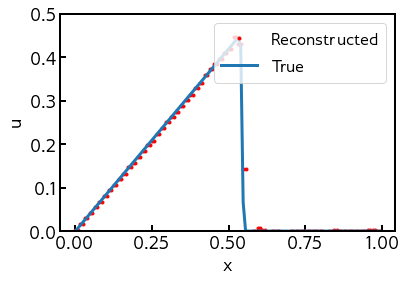

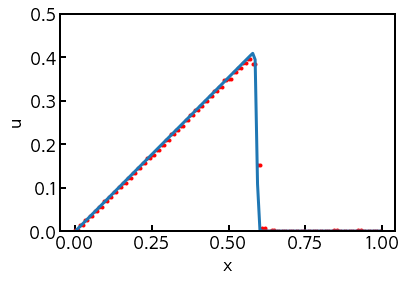

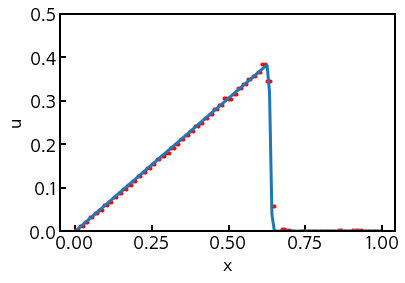

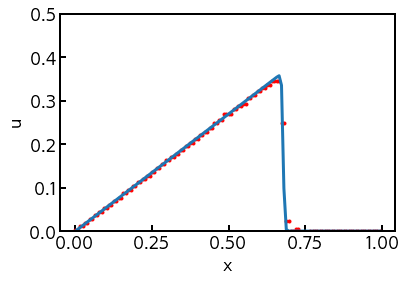

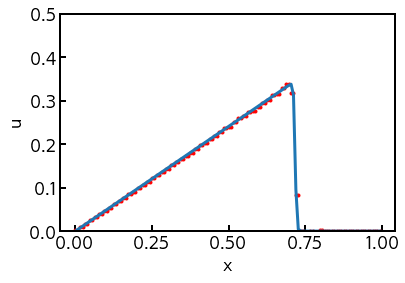

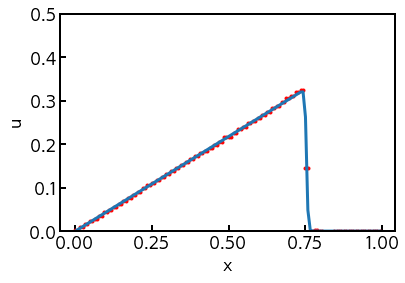

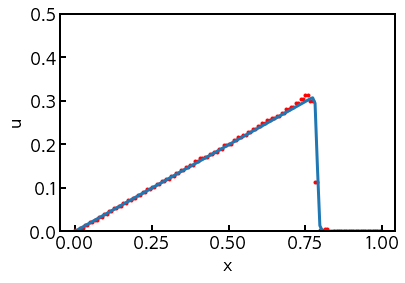

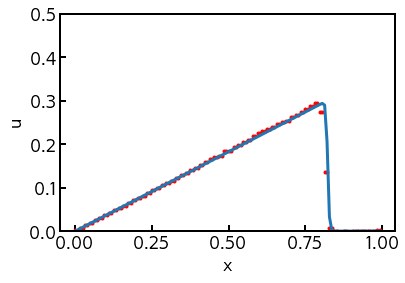

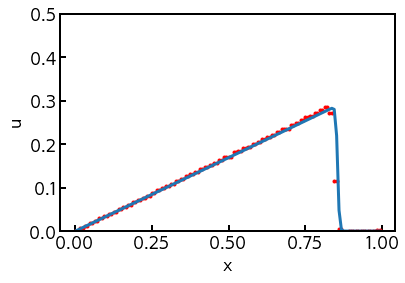

In [18]:
snapshot_test_true = np.load('Testing_data.npy')
snapshot_test_pred = np.load('Testing_data_prediction.npy')

x = np.arange(128)/128
snapshot_test_pred = np.copy(decoded)
num_sims = np.shape(snapshot_test_true)[0]
animate = True

test_num = -1
snap = 10
if animate:
    for i in range(time_window,num_time_steps,int(num_time_steps/9)):
        plt.figure()    
        plt.plot(x,decoded[test_num,i-time_window,:],'ro',label='Reconstructed',markersize=3)
        plt.plot(x,snapshot_test_true[test_num,i,:],label='True',linewidth=3)    
        plt.ylim((0.0,0.5))        
        if i == time_window:
            plt.legend(loc='upper right')
            
        plt.xlabel('x')
        plt.ylabel('u')
        plt.savefig('MP_Reconstruction_'+str(snap)+'.png')
        snap = snap + 10
        plt.show()

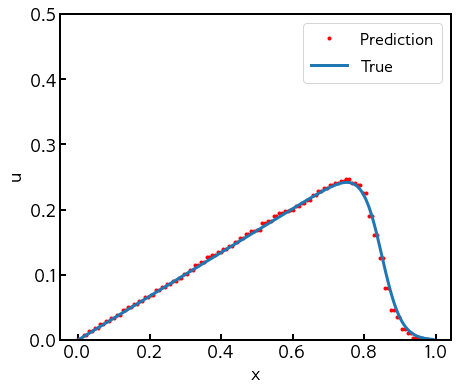

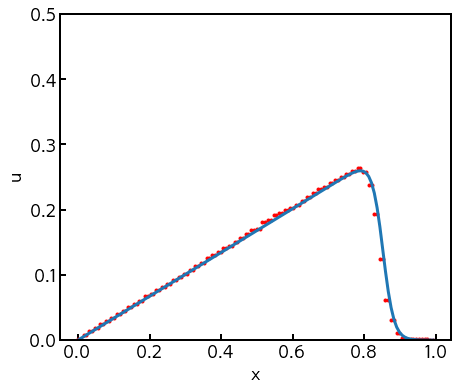

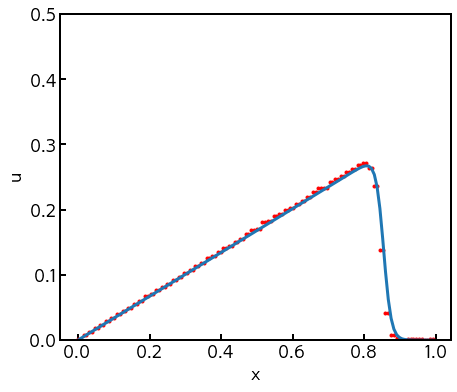

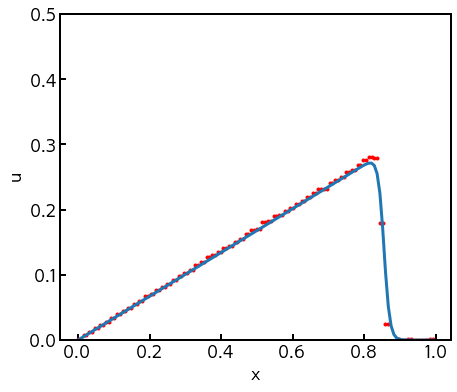

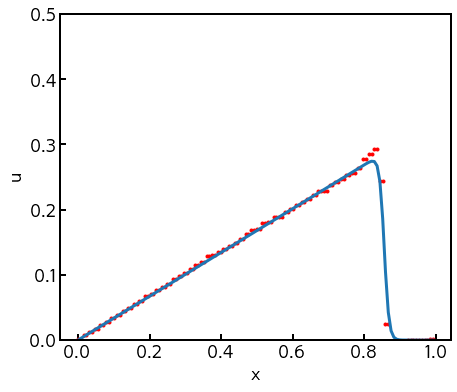

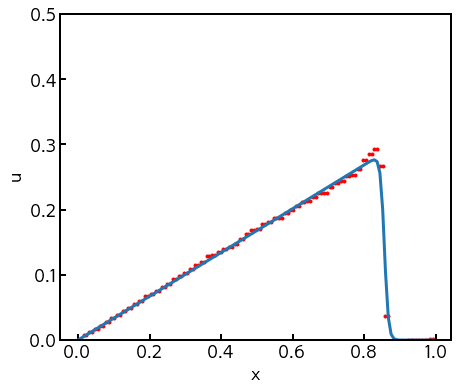

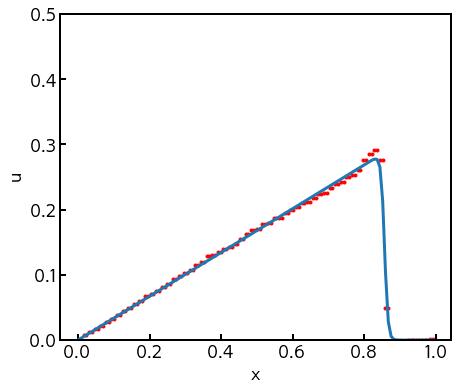

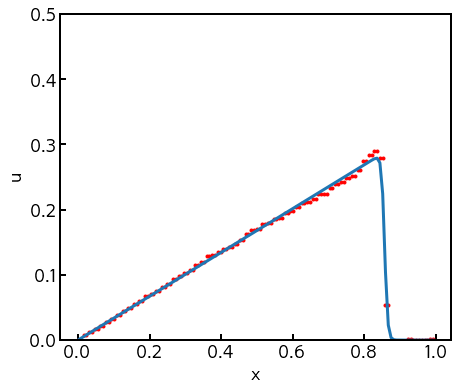

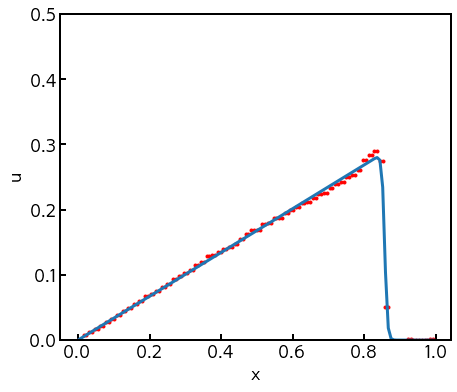

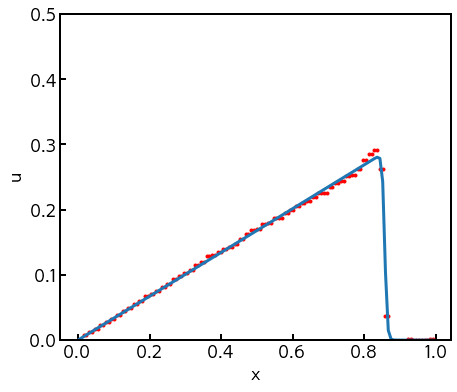

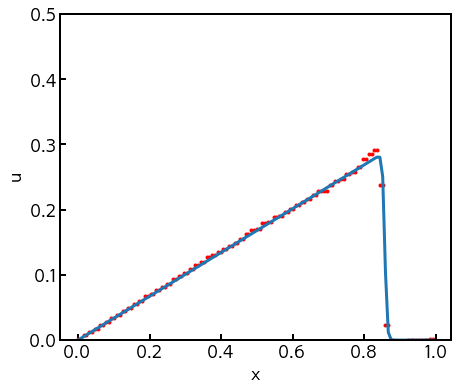

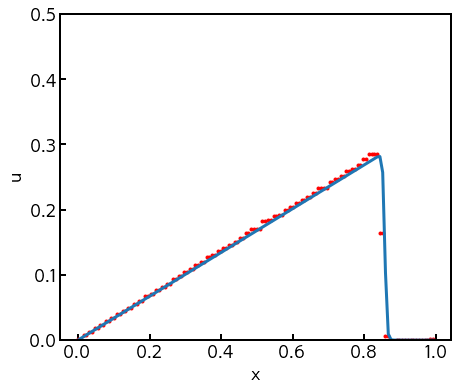

In [19]:
for sim in range(1,num_sims):
    plt.figure(figsize=(7,6))
    plt.plot(x,decoded[sim,-1,:],'ro',label='Prediction',markersize=3)
    plt.plot(x,snapshot_test_true[sim,-1,:],label='True',linewidth=3)

    plt.ylim((0.0,0.5))
    if sim == 1:
        plt.legend()
        
    plt.xlabel('x')
    plt.ylabel('u')
    plt.savefig('MP_Reconstruction_tf_'+str(sim)+'.png')
    plt.show()

In [24]:
np.mean((snapshot_test_true[:,-1,:] - snapshot_test_pred[:,-1,:])**2)

0.00011745258999848746